# Finetuning OCSVM with Corss-Validation

### Imports

In [3]:
import pandas as pd
import numpy as np 
import math
import os
import pickle
import gc 
from tqdm import tqdm
from datetime import datetime
from sklearn.model_selection import GridSearchCV, cross_validate, train_test_split
from sklearn.metrics import make_scorer
from sklearn.svm import OneClassSVM
from sys import getsizeof
from scipy import special
import matplotlib.pyplot as plt
from pandarallel import pandarallel
import tensorflow as tf 

def q_func(x):
    q = 0.5 - 0.5*special.erf(x / np.sqrt(2))
    return q

def friis_calc(P,freq,dist,ple):
    '''
    Friis path loss equation
    P = Tx transmit power
    freq = Signal frequency
    dist = Transmission distance
    ple = Path loss exponent
    '''
    propagation_speed = 299792458
    l = propagation_speed / freq
    h_pl = P * l**2 / (16*math.pi**2)
    P_Rx = h_pl * dist**(-ple)
    return P_Rx

def plos_calc(h_dist, height_tx, height_rx, env='suburban'):
    '''
    % This function implements the LoS probability model from the paper
    % "Blockage Modeling for Inter-layer UAVs Communications in Urban
    % Environments" 
    % param h_dist    : horizontal distance between Tx and Rx (m)
    % param height_tx : height of Tx
    % param height_rx : height of Rx
    '''
    if env == 'suburban':
        a1 = 0.1
        a2 = 7.5e-4
        a3 = 8
    
    delta_h = height_tx - height_rx
    # pow_factor = 2 * h_dist * math.sqrt(a1*a2/math.pi) + a1 # NOTE: Use this pow_factor if assuming PPP building dist.
    pow_factor = h_dist * math.sqrt(a1*a2) # NOTE: Use this pow_factor if assuming ITU-R assumptions.
    if delta_h == 0:
        p = (1 - math.exp((-(height_tx)**2) / (2*a3**2))) ** pow_factor
    else:
        delta_h = abs(delta_h)
        p = (1 - (math.sqrt(2*math.pi)*a3 / delta_h) * abs(q_func(height_tx/a3) - q_func(height_rx/a3))) ** pow_factor
    return p

def sinr_lognormal_approx(h_dist, height, env='suburban'):
    '''
    To approximate the SNR from signal considering multipath fading and shadowing
    Assuming no interference due to CSMA, and fixed noise
    Inputs:
    h_dist = Horizontal Distance between Tx and Rx
    height = Height difference between Tx and Rx
    env = The operating environment (currently only suburban supported)
    '''
    # Signal properties
    P_Tx_dBm = 20 # Transmit power of 
    P_Tx = 10**(P_Tx_dBm/10) / 1000
    freq = 2.4e9 # Channel frequency (Hz)
    noise_dBm = -86
    noise = 10**(noise_dBm/10) / 1000
    if env == "suburban":
        # ENV Parameters Constants ----------------------------------
        # n_min = 2
        # n_max = 2.75
        # K_dB_min = 7.8
        # K_dB_max = 17.5
        # K_min = 10**(K_dB_min/10)
        # K_max = 10**(K_dB_max/10)
        # alpha = 11.25 # Env parameters for logarithm std dev of shadowing 
        # beta = 0.06 # Env parameters for logarithm std dev of shadowing 
        n_min = 2
        n_max = 2.75
        K_dB_min = 1.4922
        K_dB_max = 12.2272
        K_min = 10**(K_dB_min/10)
        K_max = 10**(K_dB_max/10)
        alpha = 11.1852 # Env parameters for logarithm std dev of shadowing 
        beta = 0.06 # Env parameters for logarithm std dev of shadowing 
        # -----------------------------------------------------------
    # Calculate fading parameters
    PLoS = plos_calc(h_dist, 0, height, env='suburban')
    theta_Rx = math.atan2(height, h_dist) * 180 / math.pi # Elevation angle in degrees
    ple = (n_min - n_max) * PLoS + n_max # Path loss exponent
    sigma_phi_dB = alpha*math.exp(-beta*theta_Rx)
    sigma_phi = 10**(sigma_phi_dB/10) # Logarithmic std dev of shadowing
    K = K_min * math.exp(math.log(K_max/K_min) * PLoS**2)
    omega = 1 # Omega of NCS (Rician)
    dist = math.sqrt(h_dist**2 + height**2)
    P_Rx = friis_calc(P_Tx, freq, dist, ple)
    # Approximate L-NCS RV (which is the SNR) as lognormal
    eta = math.log(10) / 10
    mu_phi = 10*math.log10(P_Rx)
    E_phi = math.exp(eta*mu_phi + eta**2*sigma_phi**2/2) # Mean of shadowing RV
    var_phi = math.exp(2*eta*mu_phi+eta**2*sigma_phi**2)*(math.exp(eta**2*sigma_phi**2)-1) # Variance of shadowing RV
    E_chi = (special.gamma(1+1)/(1+K))*special.hyp1f1(-1,1,-K)*omega
    var_chi = (special.gamma(1+2)/(1+K)**2)*special.hyp1f1(-2,1,-K)*omega**2 - E_chi**2
    E_SNR = E_phi * E_chi / noise # Theoretical mean of SINR
    var_SNR = ((var_phi+E_phi**2)*(var_chi+E_chi**2) - E_phi**2 * E_chi**2) / noise**2
    std_dev_SNR = math.sqrt(var_SNR)
    # sigma_ln = math.sqrt(math.log(var_SNR/E_SNR**2 + 1))
    # mu_ln = math.log(E_SNR) - sigma_ln**2/2
    return E_SNR, std_dev_SNR

def get_measured_throughput(sim_root_path, link="Downlink", single_path = False):
    '''
    Function to load the processed measured throughput data from CSV files stored in different subdirs in sim_root_path
    '''
    assert link in ["Downlink", "Uplink", "Video"], 'link must be one of "Downlink", "Uplink", "Video"'
    df_list = []
    if single_path:
        scenario_list = [sim_root_path]
    else:
        scenario_list = [f.path for f in os.scandir(sim_root_path) if f.is_dir()] # Get list of "unique" scenarios
    for scenario in tqdm(scenario_list):
        # Get the measured throughput samples under this scenario
        measured_df = pd.read_csv(os.path.join(scenario, link + "_Throughput.csv"))
        df_list.append(measured_df)
    return pd.concat(df_list)

def normalize_data(df_in, columns, link, save_details_path=None):
    '''
    columns: The pandas data columns to normalize, given as a list of column names
    link is the link type, for choosing the range of measured throughput to scale the data
    '''
    assert link in ["Downlink", "Uplink", "Video"], 'link must be one of "Downlink", "Uplink", "Video"'
    df = df_in.copy()
    # Define the ranges of parametrers
    max_mean_sinr = 10*math.log10(1123) # The max mean SINR calculated at (0,60) is 1122.743643457063 (linear)
    max_std_dev_sinr = 10*math.log10(466) # The max std dev SINR calculated at (0,60) is 465.2159856885714 (linear)
    min_mean_sinr = 10*math.log10(0.2) # The min mean SINR calculated at (1200,60) is 0.2251212887895188 (linear)
    min_std_dev_sinr = 10*math.log10(0.7) # The min std dev SINR calculated at (1200,300) is 0.7160093126585219 (linear)
    max_height = 300
    min_height = 60
    max_h_dist = 1200
    min_h_dist = 0
    max_mcs = 7
    min_mcs = 0
    max_uav_speed = 26
    min_uav_speed = 0
    if link == "Downlink":
        max_throughput = 16000 # Max measured throughput for DJI Spark Downlink is 15968 bytes/sec
    elif link == "Uplink":
        max_throughput = 565000 # Max measured throughput for DJI Spark Uplink is 564990 bytes/sec
    elif link == "Video":
        max_throughput = 300000 # Max measured throughput for DJI Spark Video Link is 298700 bytes/sec
    min_throughput = 0

    # Normalize data (Min Max Normalization between [-1,1])
    if "Height" in columns:
        df["Height"] = df["Height"].apply(lambda x: 2*(x-min_height)/(max_height-min_height) - 1)
    if "U2G_H_Dist" in columns:
        df["U2G_H_Dist"] = df["U2G_H_Dist"].apply(lambda x: 2*(x-min_h_dist)/(max_h_dist-min_h_dist) - 1)
    if "Horizontal_Distance" in columns:
        df["Horizontal_Distance"] = df["Horizontal_Distance"].apply(lambda x: 2*(x-min_h_dist)/(max_h_dist-min_h_dist) - 1)
    if "Mean_SINR" in columns:
        df["Mean_SINR"] = df["Mean_SINR"].apply(lambda x: 2*(10*math.log10(x)-min_mean_sinr)/(max_mean_sinr-min_mean_sinr) - 1) # Convert to dB space
    if "Std_Dev_SINR" in columns:
        df["Std_Dev_SINR"] = df["Std_Dev_SINR"].apply(lambda x: 2*(10*math.log10(x)-min_std_dev_sinr)/(max_std_dev_sinr-min_std_dev_sinr) - 1) # Convert to dB space
    if "UAV_Sending_Interval" in columns:
        df["UAV_Sending_Interval"] = df["UAV_Sending_Interval"].replace({10:-1, 20:-0.5, 40:0, 66.7: 0.5, 100:1, 1000:2})
    if "Packet_State" in columns:
        df['Packet_State'] = df['Packet_State'].replace({"Reliable":0, "QUEUE_OVERFLOW":1, "RETRY_LIMIT_REACHED":2, "Delay_Exceeded":3})
    if "Modulation" in columns:
        df['Modulation'] = df['Modulation'].replace({"BPSK":1, "QPSK":0.3333, 16:-0.3333, "QAM-16":-0.3333, "QAM16":-0.3333, 64:-1, "QAM-64":-1, "QAM64":-1})
    if "MCS" in columns:
        df["MCS"] = df["MCS"].apply(lambda x: 2*(x-min_mcs)/(max_mcs-min_mcs) - 1)
    if "MCS_Index" in columns:
        df["MCS_Index"] = df["MCS_Index"].apply(lambda x: 2*(x-min_mcs)/(max_mcs-min_mcs) - 1)
    if "UAV_Speed" in columns:
        df["UAV_Speed"] = df["UAV_Speed"].apply(lambda x: 2*(x-min_uav_speed)/(max_uav_speed-min_uav_speed) - 1)
    if "Throughput" in columns:
        df["Throughput"] = df["Throughput"].apply(lambda x: 2*(x-min_throughput)/(max_throughput-min_throughput) - 1)


    # Record details of inputs and output for model
    if save_details_path is not None:
        f = open(os.path.join(save_details_path,"model_details.txt"), "w")
        f.write("Max Height (m): {}\n".format(max_height))
        f.write("Min Height (m): {}\n".format(min_height))
        f.write("Max H_Dist (m): {}\n".format(max_h_dist))
        f.write("Min H_Dist (m): {}\n".format(min_h_dist))
        f.write("Max Mean SINR (dB): {}\n".format(max_mean_sinr))
        f.write("Min Mean SINR (dB): {}\n".format(min_mean_sinr))
        f.write("Max Std Dev SINR (dB): {}\n".format(max_std_dev_sinr))
        f.write("Min Std Dev SINR (dB): {}\n".format(min_std_dev_sinr))
        f.write("Max UAV Speed (m/s): {}\n".format(max_uav_speed))
        f.write("Min UAV Speed (m/s): {}\n".format(min_uav_speed))
        f.write("Max Measured Throughput (bytes/sec): {}\n".format(max_throughput))
        f.write("Min Measured Throughput (bytes/sec): {}\n".format(min_throughput))
        f.write("[BPSK: 1, QPSK: 0.3333, QAM16: -0.3333, QAM64: -1]\n")
        f.write("UAV Sending Interval: [10:-1, 20:-0.5, 40:0, 66.7: 0.5, 100:1, 1000:2]\n")
        f.write("Output: ['Reliable':0, 'QUEUE_OVERFLOW':1, 'RETRY_LIMIT_REACHED':2, 'Delay_Exceeded':3]\n")
        f.close()

    return df

def get_mcs_index(df_in):
    '''
    Gets the MCS index based on modulation and bitrate column of the df_in
    '''
    df = df_in.copy()
    df["MCS"] = ''
    df.loc[(df["Modulation"] == "BPSK") & (df["Bitrate"] == 6.5), "MCS"] = 0 # MCS Index 0
    df.loc[(df["Modulation"] == "QPSK") & (df["Bitrate"] == 13), "MCS"] = 1 # MCS Index 0
    df.loc[(df["Modulation"] == "QPSK") & (df["Bitrate"] == 19.5), "MCS"] = 2 # MCS Index 0
    df.loc[(df["Modulation"] == "QAM16") & (df["Bitrate"] == 26), "MCS"] = 3 # MCS Index 0
    df.loc[(df["Modulation"] == "QAM16") & (df["Bitrate"] == 39), "MCS"] = 4 # MCS Index 0
    df.loc[(df["Modulation"] == "QAM64") & (df["Bitrate"] == 52), "MCS"] = 5 # MCS Index 0
    df.loc[(df["Modulation"] == "QAM64") & (df["Bitrate"] == 58.5), "MCS"] = 6 # MCS Index 0
    df.loc[(df["Modulation"] == "QAM64") & (df["Bitrate"] == 65), "MCS"] = 7 # MCS Index 0

    return df

def norm_MCS(mcs_index):
    return 2*mcs_index/7 - 1

2023-11-22 22:06:41.118518: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-22 22:06:41.246673: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-22 22:06:41.251830: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-11-22 22:06:41.251848: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

2023-11-22 22:06:41.818359: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-11-22 22:06:41.818426: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-11-22 22:06:41.818434: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


### Find critical distance for a scenario

In [4]:
# Load model
dl_model = tf.keras.models.load_model("/media/research-student/One Touch/FANET Datasets/Dataset_NP10000_DJISpark/nn_checkpoints/djispark_nnv4_wobn_dl/model.010-0.2039.h5", compile=False)
dl_model.compile(optimizer='adam', 
              loss={'packet_state': 'categorical_crossentropy'},
              metrics={'packet_state': 'accuracy'})

max_mean_sinr = 10*math.log10(1123) # The max mean SINR calculated at (0,60) is 1122.743643457063 (linear)
max_std_dev_sinr = 10*math.log10(466) # The max std dev SINR calculated at (0,60) is 465.2159856885714 (linear)
min_mean_sinr = 10*math.log10(0.2) # The min mean SINR calculated at (1200,60) is 0.2251212887895188 (linear)
min_std_dev_sinr = 10*math.log10(0.7) # The min std dev SINR calculated at (1200,300) is 0.7160093126585219 (linear)

uav_send_int = 100
uav_send_int_norm = {10:-1, 20:-0.5, 40:0, 66.7: 0.5, 100:1, 1000:2}
mcs_index = 1
heights = [60, 90, 120, 150, 180, 210, 240, 270, 300]
horizontal_dist = np.linspace(0, 1200, 121, endpoint=True)
reliability_th = 0.99 # Threshold for reliability value
crit_dist = [] # The critical distance corresponding to each height
for height in heights:
    stop = 0
    for h_dist in horizontal_dist:
        if stop == 0:
            m, s = sinr_lognormal_approx(h_dist, height)
            m = 2*(10*math.log10(m)-min_mean_sinr)/(max_mean_sinr-min_mean_sinr) - 1
            s = 2*(10*math.log10(s)-min_std_dev_sinr)/(max_std_dev_sinr-min_std_dev_sinr) - 1
            predicted_reliability = dl_model.predict([[m, s, uav_send_int_norm[uav_send_int], norm_MCS(mcs_index)]])[0][0]
            if predicted_reliability < reliability_th:
                stop = 1
                crit_dist.append(h_dist)
max_crit_dist = np.max(crit_dist)

2023-11-22 22:06:45.869108: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-11-22 22:06:45.869214: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2023-11-22 22:06:45.869283: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2023-11-22 22:06:45.869348: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcufft.so.10'; dlerror: libcufft.so.10: cannot open shared object file: No such file or directory
2023-11-22 22:06:45.869410: W tensorflow/stream_executor/platform/default/dso_loader.cc:64

1/1 [==============================] - 0s 39ms/step


### Load Training Data

In [97]:
DATASET_PATH = "/media/research-student/One Touch/FANET Datasets/DJISpark_Measured_Throughput_10000Samples/data_processed" 
LINK = "Downlink"

pandarallel.initialize(progress_bar=False)

throughput_df = get_measured_throughput(DATASET_PATH, LINK)

"""Filter scenario"""
# Filter by UAV sending interval and MCS
throughput_df = throughput_df.loc[(throughput_df["UAV_Sending_Interval"]==uav_send_int) & (throughput_df["MCS_Index"]==mcs_index)]

# For each height, get the data up to the critical distance
df = []
for h, cd in zip(heights, crit_dist):
    tmp_df = throughput_df.loc[(throughput_df["Height"]==h) & (throughput_df["Horizontal_Distance"]<=cd)]
    if not tmp_df.empty:
        df.append(tmp_df)
throughput_df = pd.concat(df)

# Get SNR and normalize data
throughput_df[['Mean_SINR',"Std_Dev_SINR"]] = throughput_df.parallel_apply(lambda row: sinr_lognormal_approx(row['Horizontal_Distance'],row['Height']),axis=1,result_type='expand')
throughput_df_norm = normalize_data(throughput_df, columns=["Horizontal_Distance", "Mean_SINR", "Std_Dev_SINR", "UAV_Sending_Interval", "MCS_Index", "UAV_Speed", "Throughput"], link=LINK)              

# Get only inputs  for model
# X_train = throughput_df[["Mean_SINR", "Std_Dev_SINR", "UAV_Sending_Interval", "MCS_Index", "UAV_Speed", "Throughput"]].values
# X_train = throughput_df_norm[["Mean_SINR", "Std_Dev_SINR", "UAV_Speed", "Throughput"]].values
X_train = throughput_df_norm[["Mean_SINR", "Std_Dev_SINR", "Throughput"]].values


INFO: Pandarallel will run on 20 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


100%|██████████| 1152/1152 [00:06<00:00, 181.38it/s]


### Split training dataset into training and holdout datasets

In [81]:
from sklearn.model_selection import train_test_split

X_train, X_holdout = train_test_split(X_train, test_size=0.2, stratify=throughput_df["UAV_Speed"].values, random_state=0)

### Train OCSVM

In [64]:
def custom_loss_score(y_true, y_pred, accuracy_goal):
    # LOWER BETTER
    y_true = (y_true + 1) / 2 # To convert the range from -1:1 to 0:1
    y_pred = (y_pred + 1) / 2 # To convert the range from -1:1 to 0:1
    sum_diff = np.abs(y_true - y_pred).sum() # y_true and y_pred should only be 0 or 1
    accuracy = 1 - sum_diff / len(y_true)
    # if accuracy < accuracy_goal: # Set minimum accuracy requirements
    #     return 1
    # else:
    #     return np.abs(accuracy - accuracy_goal) # How far is the accuracy from the goal?
    return np.abs(accuracy - accuracy_goal) # How far is the accuracy from the goal?

### Finetune OCSVM Nu with Cross-Validation

In [88]:
score_threshold = 1
nu = np.logspace(2, 7, num=6, endpoint=True, base=0.1)
gamma = np.linspace(1,10,10) # np.logspace(-2, 2, 5)
parameters = {'gamma': gamma, 'nu': nu, 'kernel': ['rbf']}
model = OneClassSVM()
my_scorer = make_scorer(custom_loss_score, greater_is_better=False, accuracy_goal=score_threshold)
clf = GridSearchCV(estimator=model, 
                   param_grid=parameters,
                   cv=5,
                   scoring=my_scorer,
                   n_jobs=20, # -1 to use all procs
                   verbose=3) 
clf.fit(X_train, np.ones(len(X_train)))

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[CV 1/5] END gamma=1.0, kernel=rbf, nu=1.0000000000000003e-05;, score=-0.000 total time=   0.1s
[CV 1/5] END gamma=1.0, kernel=rbf, nu=0.00010000000000000002;, score=-0.000 total time=   0.1s
[CV 2/5] END gamma=1.0, kernel=rbf, nu=1.0000000000000003e-05;, score=-0.000 total time=   0.1s
[CV 5/5] END gamma=1.0, kernel=rbf, nu=0.00010000000000000002;, score=-0.000 total time=   0.1s
[CV 2/5] END gamma=1.0, kernel=rbf, nu=0.00010000000000000002;, score=-0.000 total time=   0.1s
[CV 1/5] END gamma=1.0, kernel=rbf, nu=1.0000000000000002e-06;, score=-0.001 total time=   0.1s
[CV 2/5] END gamma=1.0, kernel=rbf, nu=1.0000000000000002e-06;, score=-0.000 total time=   0.1s
[CV 3/5] END gamma=1.0, kernel=rbf, nu=1.0000000000000002e-06;, score=-0.001 total time=   0.1s
[CV 4/5] END gamma=1.0, kernel=rbf, nu=1.0000000000000002e-06;, score=-0.000 total time=   0.1s
[CV 3/5] END gamma=1.0, kernel=rbf, nu=0.00010000000000000002;, score=-0.000 total time=   0.1s
[CV 5/5] END gamma=1.0, kernel=rbf, nu=1

GridSearchCV(cv=5, estimator=OneClassSVM(), n_jobs=20,
             param_grid={'gamma': array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
                         'kernel': ['rbf'],
                         'nu': array([1.e-02, 1.e-03, 1.e-04, 1.e-05, 1.e-06, 1.e-07])},
             scoring=make_scorer(custom_loss_score, greater_is_better=False, accuracy_goal=1),
             verbose=3)

In [89]:
clf.best_params_

{'gamma': 1.0, 'kernel': 'rbf', 'nu': 0.00010000000000000002}

In [158]:
clf.cv_results_

{'mean_fit_time': array([10.43244762,  0.84858155,  0.1596992 ,  0.12194285,  0.07466731,
         0.05354657,  9.18000321,  0.91673183,  0.24525523,  0.18982668,
         0.15516782,  0.06258707,  9.23704195,  1.09131131,  0.41313858,
         0.32319098,  0.1917707 ,  0.07271938, 10.99201198,  0.74541516,
         0.35045714,  0.28576078,  0.13808722,  0.04966717,  7.81346159,
         1.40580621,  0.71758251,  0.46625409,  0.20416594,  0.06882176,
         9.73127255,  1.63768454,  0.8846591 ,  0.58384271,  0.25011096,
         0.07701707,  9.96692896,  1.80491629,  0.72219381,  0.6125526 ,
         0.18829641,  0.06623445,  9.71879363,  1.93661962,  1.11176171,
         0.61023083,  0.28000202,  0.08035812,  9.6828517 ,  1.82340956,
         1.06725283,  0.50758791,  0.23946609,  0.0917325 ,  7.66633258,
         1.92321262,  1.27600975,  0.715487  ,  0.29888625,  0.08816438]),
 'std_fit_time': array([1.45576539, 0.13871365, 0.03041285, 0.01839889, 0.00819855,
        0.00672947, 1

### Cross-Val Accuracy of Best Model on Train Data

In [41]:
from sklearn.model_selection import cross_validate

svm = OneClassSVM(kernel='rbf', nu=1e-5, gamma=5)
cv_results = cross_validate(svm, X_train, np.ones(len(X_train)),
                            scoring='accuracy',
                            cv=5,
                            n_jobs=10,
                            return_estimator=True)

accuracies = []
for i in range(len(cv_results['estimator'])):
    model = cv_results['estimator'][i]
    y_pred_cv = model.predict(X_train)
    y_pred_cv = (y_pred_cv + 1) // 2 # To convert the range from -1:1 to 0:1
    accuracies.append(np.sum(y_pred_cv) / len(X_train)) # Ground truth is all 1 for normal test data
print(np.mean(accuracies))

0.9972299753498499


#### Accuracy on Train Data

In [42]:
svm = OneClassSVM(kernel='rbf', nu=1e-5, gamma=5)
svm.fit(X_train)

# Get OCSVM Accuracy on train dataset
y_pred = svm.predict(X_train)
y_pred = (y_pred + 1) // 2 # To convert the range from -1:1 to 0:1
train_normal_accuracy = np.sum(y_pred) / len(X_train) # Ground truth is all 1 for normal test data
print(train_normal_accuracy)

0.9973527465254798


### Train Best Model and Test on Test Dataset for Normal Cases (No Anomaly)

In [90]:
svm = OneClassSVM(kernel='rbf', nu=1e-5, gamma=5)

svm.fit(X_train)

OneClassSVM(gamma=1, nu=0.0001)

#### Load Test Dataset (Non-Anomalous)

In [92]:
# Load Non-Anomalous Test Dataset
DATASET_PATH = "/media/research-student/One Touch/FANET Datasets/Test_Dataset_DJISpark_Throughput_Taguchi_v2/data_processed" 
LINK = "Downlink"

throughput_test_df = get_measured_throughput(DATASET_PATH, LINK, single_path=False)

# # Filter scenario
throughput_test_df = throughput_test_df.loc[(throughput_test_df["UAV_Sending_Interval"]==uav_send_int) & (throughput_test_df["MCS_Index"]==mcs_index)]
# Find crit distance and filter DF
test_horizontal_dist = np.linspace(0, 1200, 121, endpoint=True)
test_height = [75, 135, 225, 285]
test_crit_dist = [] # The critical distance corresponding to each height
for height in test_height:
    stop = 0
    for h_dist in test_horizontal_dist:
        if stop == 0:
            m, s = sinr_lognormal_approx(h_dist, height)
            m = 2*(10*math.log10(m)-min_mean_sinr)/(max_mean_sinr-min_mean_sinr) - 1
            s = 2*(10*math.log10(s)-min_std_dev_sinr)/(max_std_dev_sinr-min_std_dev_sinr) - 1
            predicted_reliability = dl_model.predict([[m, s, uav_send_int_norm[uav_send_int], norm_MCS(mcs_index)]])[0][0]
            if predicted_reliability < reliability_th:
                stop = 1
                test_crit_dist.append(h_dist)
# For each height, get the data up to the critical distance
test_df = []
for h, cd in zip(test_height, test_crit_dist):
    tmp_df = throughput_test_df.loc[(throughput_test_df["Height"]==h) & (throughput_test_df["Horizontal_Distance"]<=cd)]
    if not tmp_df.empty:
        test_df.append(tmp_df)
throughput_test_df = pd.concat(test_df)
throughput_test_df[['Mean_SINR',"Std_Dev_SINR"]] = throughput_test_df.parallel_apply(lambda row: sinr_lognormal_approx(row['Horizontal_Distance'],row['Height']),axis=1,result_type='expand')
throughput_test_df_norm = normalize_data(throughput_test_df, columns=["Horizontal_Distance", "Mean_SINR", "Std_Dev_SINR", "UAV_Sending_Interval", "MCS_Index", "UAV_Speed", "Throughput"], link=LINK)              
# Get only inputs  for model
# X_test = throughput_test_df_norm[["Mean_SINR", "Std_Dev_SINR", "UAV_Sending_Interval", "MCS_Index", "UAV_Speed", "Throughput"]].values
# X_test = throughput_test_df_norm[["Mean_SINR", "Std_Dev_SINR", "UAV_Speed", "Throughput"]].values
X_test = throughput_test_df_norm[["Mean_SINR", "Std_Dev_SINR", "Throughput"]].values

100%|██████████| 12/12 [00:00<00:00, 147.65it/s]

1/1 [==============================] - 0s 42ms/step


1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 36ms/step


#### Test Model on Test Dataset (Non-Anomalous)

In [93]:
# Get OCSVM Accuracy
y_pred = svm.predict(X_test)
y_pred = (y_pred + 1) // 2 # To convert the range from -1:1 to 0:1
throughput_test_df["Y_Pred"] = y_pred
test_normal_accuracy = np.sum(y_pred) / len(X_test) # Ground truth is all 1 for normal test data
print(test_normal_accuracy)

0.9998522458628841


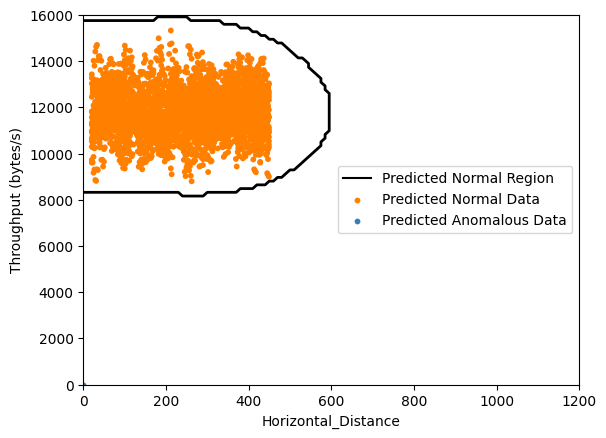

In [95]:
# Plotting Test Results
max_mean_sinr = 10*math.log10(1123) # The max mean SINR calculated at (0,60) is 1122.743643457063 (linear)
max_std_dev_sinr = 10*math.log10(466) # The max std dev SINR calculated at (0,60) is 465.2159856885714 (linear)
min_mean_sinr = 10*math.log10(0.2) # The min mean SINR calculated at (1200,60) is 0.2251212887895188 (linear)
min_std_dev_sinr = 10*math.log10(0.7) # The min std dev SINR calculated at (1200,300) is 0.7160093126585219 (linear)
max_h_dist = 1200
min_h_dist = 0
max_uav_speed = 26
min_uav_speed = 0
if LINK == "Downlink":
    max_throughput = 16000 # Max measured throughput for DJI Spark Downlink is 15968 bytes/sec
elif LINK == "Uplink":
    max_throughput = 565000 # Max measured throughput for DJI Spark Uplink is 564990 bytes/sec
elif LINK == "Video":
    max_throughput = 300000 # Max measured throughput for DJI Spark Video Link is 298700 bytes/sec
min_throughput = 0

xx, yy = np.meshgrid(np.linspace(min_h_dist, max_h_dist, 121), np.linspace(min_throughput, max_throughput, 100))
yy_norm = 2*yy/max_throughput - 1
mean_sinr = []
std_dev_sinr = []
# height = throughput_test_df["Height"].max()
height = 225
speed = throughput_test_df["UAV_Speed"].max()
speed_norm = 2*(speed-min_uav_speed)/(max_uav_speed-min_uav_speed) - 1
for x in xx.ravel():
    m, s = sinr_lognormal_approx(x, height)
    m = 2*(10*math.log10(m)-min_mean_sinr)/(max_mean_sinr-min_mean_sinr) - 1
    s = 2*(10*math.log10(s)-min_std_dev_sinr)/(max_std_dev_sinr-min_std_dev_sinr) - 1
    mean_sinr.append(m)
    std_dev_sinr.append(s)
# Get contour for model
# Z1 = svm.predict(np.c_[mean_sinr, std_dev_sinr, np.ones(len(mean_sinr))*speed_norm, yy_norm.ravel()])
Z1 = svm.predict(np.c_[mean_sinr, std_dev_sinr, yy_norm.ravel()])
Z1 = Z1.reshape(xx.shape)
plt.contour(xx, yy, Z1, levels=[0], linewidths=2, colors="black")

# Run inference on test data in previous code block first!!!
throughput_test_df_disp = throughput_test_df.loc[(throughput_test_df["Height"]==height) & (throughput_test_df["UAV_Speed"]==speed)] # Filter for certain height and speed
colors = np.array(["#377eb8", "#ff7f00"])
plt.scatter(throughput_test_df_disp["Horizontal_Distance"].values, throughput_test_df_disp["Throughput"].values, s=10, color=colors[throughput_test_df_disp["Y_Pred"].values], label="_nolegend_")
plt.plot([0], [0], color='k')
plt.scatter([0], [0], s=10, color='#ff7f00')
plt.scatter([0], [0], s=10, color='#377eb8')
plt.xlabel("Horizontal_Distance")
plt.ylabel("Throughput (bytes/s)")
plt.legend(["Predicted Normal Region", "Predicted Normal Data", "Predicted Anomalous Data"], loc='center right')

### Cross-Val Test of Best Model on Non-Anomalous Test Data

In [47]:
from sklearn.model_selection import cross_validate

svm = OneClassSVM(kernel='rbf', nu=1e-6, gamma=1)
cv_results = cross_validate(svm, X_train, np.ones(len(X_train)),
                            scoring='accuracy',
                            cv=5,
                            n_jobs=10,
                            return_estimator=True)

accuracies = []
for i in range(len(cv_results['estimator'])):
    model = cv_results['estimator'][i]
    y_pred_cv = model.predict(X_test)
    y_pred_cv = (y_pred_cv + 1) // 2 # To convert the range from -1:1 to 0:1
    accuracies.append(np.sum(y_pred_cv) / len(X_test)) # Ground truth is all 1 for normal test data
print(np.mean(accuracies))

0.9996749408983451


### Test Best Model on Test Dataset for Anomalous Cases

In [48]:
from sklearn.neighbors import LocalOutlierFactor

# Fit a LOF model so that the LOF scores can be computed
lof = LocalOutlierFactor(n_neighbors=20, novelty=True, n_jobs=20)
lof.fit(X_holdout)

LocalOutlierFactor(n_jobs=20, novelty=True)

#### Load Test Dataset (Anomalous) and Run Inference

In [49]:
# Get the LOF threshold based on training data
X_holdout_lof = - lof.negative_outlier_factor_
lof_threshold = np.percentile(X_holdout_lof, 99.5) # Take the 99.5-percentile LOF from training dataset as threshold

# Load Anomalous Test Dataset
DATASET_PATH = "/media/research-student/One Touch/FANET Datasets/Test_Dataset_Anomaly_AllType_DJISpark_Throughput/data_processed"
# DATASET_PATH = "/media/research-student/One Touch/FANET Datasets/Test_Dataset_Anomaly_AllType_DJISpark_Throughput/data_processed/UAVSpeed-12_BitRate-13_Height-225_InterferenceDistance-0_Modulation-QPSK_UAVSendingInterval-100_UAVGCSInterfererDist-500" 
LINK = "Downlink"
throughput_test_df = get_measured_throughput(DATASET_PATH, LINK, single_path=False)
# # Filter scenario
throughput_test_df = throughput_test_df.loc[(throughput_test_df["UAV_Sending_Interval"]==uav_send_int) & (throughput_test_df["MCS_Index"]==mcs_index)]
# For each height, get the data up to the critical distance (REUSE THE ONES FROM Test Data Non-Anomalous Case)
test_df = []
for h, cd in zip(test_height, test_crit_dist):
    tmp_df = throughput_test_df.loc[(throughput_test_df["Height"]==h) & (throughput_test_df["Horizontal_Distance"]<=cd)]
    if not tmp_df.empty:
        test_df.append(tmp_df)
throughput_test_df = pd.concat(test_df)
throughput_test_df[['Mean_SINR',"Std_Dev_SINR"]] = throughput_test_df.parallel_apply(lambda row: sinr_lognormal_approx(row['Horizontal_Distance'],row['Height']),axis=1,result_type='expand')
throughput_test_df_norm = normalize_data(throughput_test_df, columns=["Horizontal_Distance", "Mean_SINR", "Std_Dev_SINR", "UAV_Sending_Interval", "MCS_Index", "UAV_Speed", "Throughput"], link=LINK)              
# Get only inputs  for model
# X_test = throughput_test_df_norm[["Mean_SINR", "Std_Dev_SINR", "UAV_Speed", "Throughput"]].values
X_test = throughput_test_df_norm[["Mean_SINR", "Std_Dev_SINR", "Throughput"]].values
lof_test = - lof.score_samples(X_test)
y_test = np.where(lof_test <= lof_threshold, 1, 0) # Ground truth is where LOF score is less than threshold

100%|██████████| 9/9 [00:00<00:00, 354.88it/s]


#### Test Model on Test Dataset (Anomalous)

In [52]:
y_pred = svm.predict(X_test)
y_pred = (y_pred + 1) // 2 # To convert the range from -1:1 to 0:1
throughput_test_df["Y_Pred"] = y_pred # For plotting purposes later
throughput_test_df["Y_Test"] = y_test # For plotting purposes later
throughput_test_df["Result"] = -1 # Record the TP, TN, FP and FN
throughput_test_df.loc[(throughput_test_df["Y_Pred"]==1) & (throughput_test_df["Y_Test"]==1), "Result"] = 0 # The True Positive Results
throughput_test_df.loc[(throughput_test_df["Y_Pred"]==0) & (throughput_test_df["Y_Test"]==0), "Result"] = 1 # The True Negative Results
throughput_test_df.loc[(throughput_test_df["Y_Pred"]==1) & (throughput_test_df["Y_Test"]==0), "Result"] = 2 # The False Positive Results
throughput_test_df.loc[(throughput_test_df["Y_Pred"]==0) & (throughput_test_df["Y_Test"]==1), "Result"] = 3 # The False Negative Results
sum_diff = np.abs(y_test - y_pred).sum() # y_true and y_pred should only be 0 or 1
accuracy = 1 - sum_diff / len(y_test)
print(accuracy)

0.9714632665452337


#### Plot Results on Anomalous Test Dataset

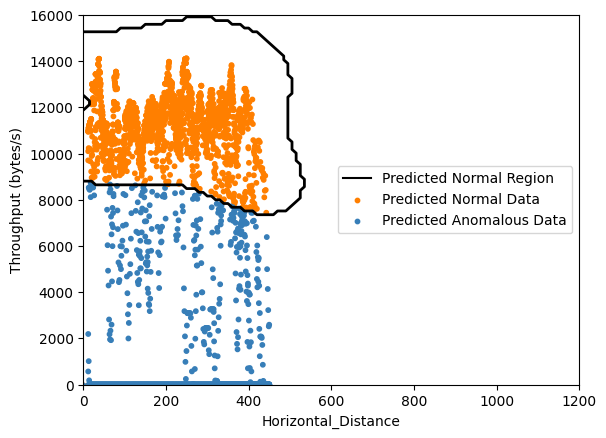

In [53]:
# Plotting Test Results
max_mean_sinr = 10*math.log10(1123) # The max mean SINR calculated at (0,60) is 1122.743643457063 (linear)
max_std_dev_sinr = 10*math.log10(466) # The max std dev SINR calculated at (0,60) is 465.2159856885714 (linear)
min_mean_sinr = 10*math.log10(0.2) # The min mean SINR calculated at (1200,60) is 0.2251212887895188 (linear)
min_std_dev_sinr = 10*math.log10(0.7) # The min std dev SINR calculated at (1200,300) is 0.7160093126585219 (linear)
max_h_dist = 1200
min_h_dist = 0
if LINK == "Downlink":
    max_throughput = 16000 # Max measured throughput for DJI Spark Downlink is 15968 bytes/sec
elif LINK == "Uplink":
    max_throughput = 565000 # Max measured throughput for DJI Spark Uplink is 564990 bytes/sec
elif LINK == "Video":
    max_throughput = 300000 # Max measured throughput for DJI Spark Video Link is 298700 bytes/sec
min_throughput = 0

xx, yy = np.meshgrid(np.linspace(min_h_dist, max_h_dist, 121), np.linspace(min_throughput, max_throughput, 100))
yy_norm = 2*yy/max_throughput - 1
mean_sinr = []
std_dev_sinr = []
height = throughput_test_df_norm["Height"].max()
speed = throughput_test_df_norm["UAV_Speed"].max()
for x in xx.ravel():
    m, s = sinr_lognormal_approx(x, height)
    m = 2*(10*math.log10(m)-min_mean_sinr)/(max_mean_sinr-min_mean_sinr) - 1
    s = 2*(10*math.log10(s)-min_std_dev_sinr)/(max_std_dev_sinr-min_std_dev_sinr) - 1
    mean_sinr.append(m)
    std_dev_sinr.append(s)
# Get contour for model
# Z1 = svm.predict(np.c_[mean_sinr, std_dev_sinr, np.ones(len(mean_sinr))*speed, yy_norm.ravel()])
Z1 = svm.predict(np.c_[mean_sinr, std_dev_sinr, yy_norm.ravel()])
Z1 = Z1.reshape(xx.shape)
plt.contour(xx, yy, Z1, levels=[0], linewidths=2, colors="black")

# Run inference on test data in previous code block first!!!
throughput_test_df_disp = throughput_test_df.loc[(throughput_test_df["Height"]==height) & (throughput_test_df_norm["UAV_Speed"]==speed)] # Filter for certain height and speed
colors = np.array(["#377eb8", "#ff7f00"])
plt.scatter(throughput_test_df_disp["Horizontal_Distance"].values, throughput_test_df_disp["Throughput"].values, s=10, color=colors[throughput_test_df_disp["Y_Pred"].values], label="_nolegend_")
plt.plot([0], [0], color='k')
plt.scatter([0], [0], s=10, color='#ff7f00')
plt.scatter([0], [0], s=10, color='#377eb8')
plt.xlabel("Horizontal_Distance")
plt.ylabel("Throughput (bytes/s)")
plt.legend(["Predicted Normal Region", "Predicted Normal Data", "Predicted Anomalous Data"], loc='center right')

#### Plot Test Samples

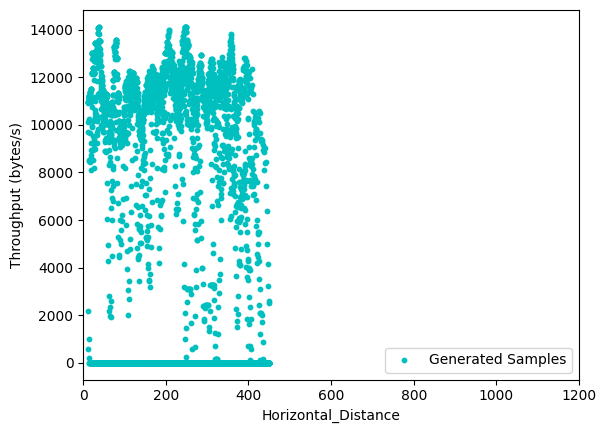

In [55]:
plt.scatter(throughput_test_df_disp["Horizontal_Distance"].values, throughput_test_df_disp["Throughput"].values, s=10, color='c', label="Generated Samples")
plt.xlabel("Horizontal_Distance")
plt.ylabel("Throughput (bytes/s)")
plt.xlim([0, 1200])
plt.legend(loc='lower right')

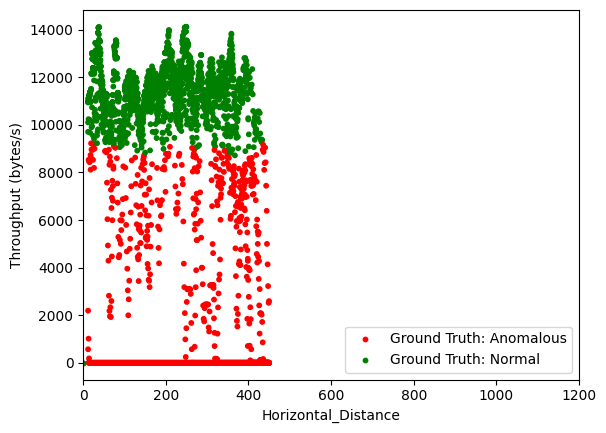

In [56]:
colors = np.array(["r", "g"])
plt.scatter(throughput_test_df_disp["Horizontal_Distance"].values, throughput_test_df_disp["Throughput"].values, s=10, color=colors[throughput_test_df_disp["Y_Test"].values], label="_nolegend_")
plt.scatter([0], [0], s=10, color='r')
plt.scatter([0], [0], s=10, color='g')
plt.xlabel("Horizontal_Distance")
plt.ylabel("Throughput (bytes/s)")
plt.xlim([0, 1200])
plt.legend(["Ground Truth: Anomalous", "Ground Truth: Normal"], loc='lower right')

#### PLot Accuracy of Anomalous Test Case

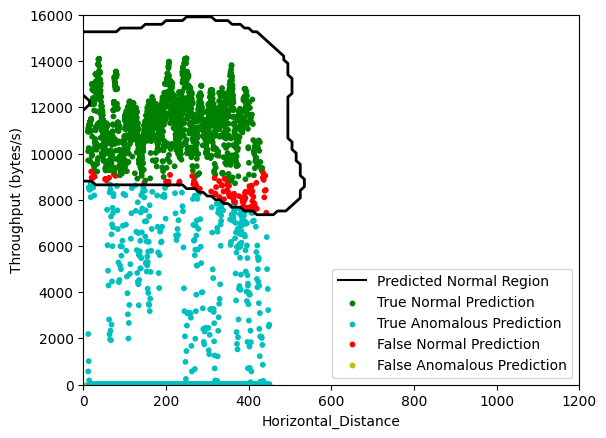

In [59]:
# Plotting Test Results
max_mean_sinr = 10*math.log10(1123) # The max mean SINR calculated at (0,60) is 1122.743643457063 (linear)
max_std_dev_sinr = 10*math.log10(466) # The max std dev SINR calculated at (0,60) is 465.2159856885714 (linear)
min_mean_sinr = 10*math.log10(0.2) # The min mean SINR calculated at (1200,60) is 0.2251212887895188 (linear)
min_std_dev_sinr = 10*math.log10(0.7) # The min std dev SINR calculated at (1200,300) is 0.7160093126585219 (linear)
max_h_dist = 1200
min_h_dist = 0
if LINK == "Downlink":
    max_throughput = 16000 # Max measured throughput for DJI Spark Downlink is 15968 bytes/sec
elif LINK == "Uplink":
    max_throughput = 565000 # Max measured throughput for DJI Spark Uplink is 564990 bytes/sec
elif LINK == "Video":
    max_throughput = 300000 # Max measured throughput for DJI Spark Video Link is 298700 bytes/sec
min_throughput = 0

xx, yy = np.meshgrid(np.linspace(min_h_dist, max_h_dist, 121), np.linspace(min_throughput, max_throughput, 100))
yy_norm = 2*yy/max_throughput - 1
mean_sinr = []
std_dev_sinr = []
height = throughput_test_df_norm["Height"].max()
speed = throughput_test_df_norm["UAV_Speed"].max()
for x in xx.ravel():
    m, s = sinr_lognormal_approx(x, height)
    m = 2*(10*math.log10(m)-min_mean_sinr)/(max_mean_sinr-min_mean_sinr) - 1
    s = 2*(10*math.log10(s)-min_std_dev_sinr)/(max_std_dev_sinr-min_std_dev_sinr) - 1
    mean_sinr.append(m)
    std_dev_sinr.append(s)
# Get contour for model
# Z1 = svm.predict(np.c_[mean_sinr, std_dev_sinr, np.ones(len(mean_sinr))*speed, yy_norm.ravel()])
Z1 = svm.predict(np.c_[mean_sinr, std_dev_sinr, yy_norm.ravel()])
Z1 = Z1.reshape(xx.shape)
plt.contour(xx, yy, Z1, levels=[0], linewidths=2, colors="black")

# Run inference on test data in previous code block first!!!
throughput_test_df_disp = throughput_test_df.loc[(throughput_test_df["Height"]==height) & (throughput_test_df_norm["UAV_Speed"]==speed)] # Filter for certain height and speed
colors = np.array(["g", "c", "r", "y"])
plt.scatter(throughput_test_df_disp["Horizontal_Distance"].values, throughput_test_df_disp["Throughput"].values, s=10, color=colors[throughput_test_df_disp["Result"].values], label="_nolegend_")
plt.plot([0], [0], color='k')
plt.scatter([0], [0], s=10, color='g')
plt.scatter([0], [0], s=10, color='c')
plt.scatter([0], [0], s=10, color='r')
plt.scatter([0], [0], s=10, color='y')
plt.xlabel("Horizontal_Distance")
plt.ylabel("Throughput (bytes/s)")
plt.legend(["Predicted Normal Region", "True Normal Prediction", "True Anomalous Prediction","False Normal Prediction", "False Anomalous Prediction"], loc='lower right')

### Cross-Val Test of Best Model on Anomalous Test Data

In [54]:
from sklearn.model_selection import cross_validate

svm = OneClassSVM(kernel='rbf', nu=1e-6, gamma=1)
cv_results = cross_validate(svm, X_train, np.ones(len(X_train)),
                            scoring='accuracy',
                            cv=5,
                            n_jobs=10,
                            return_estimator=True)

accuracies = []
for i in range(len(cv_results['estimator'])):
    model = cv_results['estimator'][i]
    y_pred_cv = model.predict(X_test)
    y_pred_cv = (y_pred_cv + 1) // 2 # To convert the range from -1:1 to 0:1
    accuracies.append(1 - np.abs(y_test - y_pred).sum() / len(y_test)) # Ground truth is all 1 for normal test data
print(np.mean(accuracies))

0.9714632665452336


### Plot Model Performance on Train Dataset

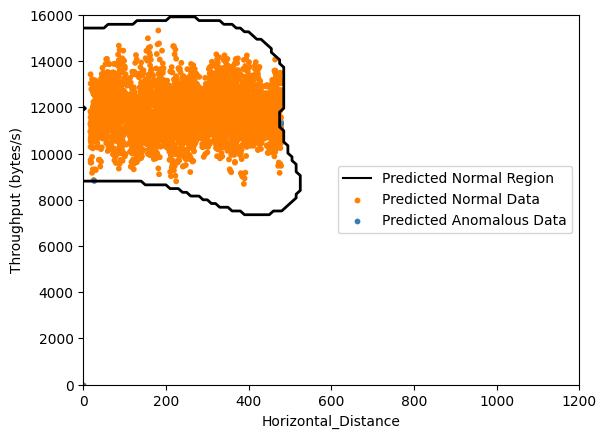

In [103]:
svm = OneClassSVM(kernel='rbf', nu=1e-5, gamma=5)
svm.fit(X_train)

# Plotting frontier of OCSVM
max_mean_sinr = 10*math.log10(1123) # The max mean SINR calculated at (0,60) is 1122.743643457063 (linear)
max_std_dev_sinr = 10*math.log10(466) # The max std dev SINR calculated at (0,60) is 465.2159856885714 (linear)
min_mean_sinr = 10*math.log10(0.2) # The min mean SINR calculated at (1200,60) is 0.2251212887895188 (linear)
min_std_dev_sinr = 10*math.log10(0.7) # The min std dev SINR calculated at (1200,300) is 0.7160093126585219 (linear)
max_h_dist = 1200
min_h_dist = 0
max_uav_speed = 26
min_uav_speed = 0
if LINK == "Downlink":
    max_throughput = 16000 # Max measured throughput for DJI Spark Downlink is 15968 bytes/sec
elif LINK == "Uplink":
    max_throughput = 565000 # Max measured throughput for DJI Spark Uplink is 564990 bytes/sec
elif LINK == "Video":
    max_throughput = 300000 # Max measured throughput for DJI Spark Video Link is 298700 bytes/sec
min_throughput = 0

xx, yy = np.meshgrid(np.linspace(min_h_dist, max_h_dist, 121), np.linspace(min_throughput, max_throughput, 100))
yy_norm = 2*yy/max_throughput - 1
mean_sinr = []
std_dev_sinr = []
height = 300
speed = 18
speed_norm = 2*(speed-min_uav_speed)/(max_uav_speed-min_uav_speed) - 1
for x in xx.ravel():
    m, s = sinr_lognormal_approx(x, height)
    m = 2*(10*math.log10(m)-min_mean_sinr)/(max_mean_sinr-min_mean_sinr) - 1
    s = 2*(10*math.log10(s)-min_std_dev_sinr)/(max_std_dev_sinr-min_std_dev_sinr) - 1
    mean_sinr.append(m)
    std_dev_sinr.append(s)
# Z1 = svm.predict(np.c_[mean_sinr, std_dev_sinr, np.ones(len(mean_sinr))*speed_norm, yy_norm.ravel()])
Z1 = svm.predict(np.c_[mean_sinr, std_dev_sinr, yy_norm.ravel()])
Z1 = Z1.reshape(xx.shape)
plt.contour(xx, yy, Z1, levels=[0], linewidths=2, colors="black")

throughput_df_disp = throughput_df.loc[(throughput_df["Height"]==height) & (throughput_df["UAV_Speed"]==speed)]
# throughput_df_disp = throughput_df.loc[(throughput_df["Height"]==height)]
throughput_df_disp_norm = normalize_data(throughput_df_disp, columns=["Horizontal_Distance", "Mean_SINR", "Std_Dev_SINR", "UAV_Sending_Interval", "MCS_Index", "UAV_Speed", "Throughput"], link=LINK)              
# X_train_disp = throughput_df_disp_norm[["Mean_SINR", "Std_Dev_SINR", "UAV_Speed", "Throughput"]].values
X_train_disp = throughput_df_disp_norm[["Mean_SINR", "Std_Dev_SINR", "Throughput"]].values
y_pred_1 = svm.predict(X_train_disp)
colors = np.array(["#377eb8", "#ff7f00"])
plt.scatter(throughput_df_disp["Horizontal_Distance"].values, throughput_df_disp["Throughput"].values, s=10, color=colors[(y_pred_1 + 1) // 2], label="_nolegend_")
plt.plot([0], [0], color='k')
plt.scatter([0], [0], s=10, color='#ff7f00')
plt.scatter([0], [0], s=10, color='#377eb8')
plt.xlabel("Horizontal_Distance")
plt.ylabel("Throughput (bytes/s)")
plt.legend(["Predicted Normal Region", "Predicted Normal Data", "Predicted Anomalous Data"], loc='center right')